<h1>Optical Character Recognition</h1>
In this project, classification is done upon images of hand written characters. A few techniques are used as classifiers, namely SGDClassifier and SVC. Accuracy and common prediction errors are discussed.

In [113]:
#import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
#import training data, and print head
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#import test data and convert to array
test_array = pd.read_csv('test.csv').to_numpy()

In [99]:
#make arrays and split training data
train_labels_temp = df['label'].to_numpy()
train_data_temp = df.drop(labels='label', axis=1).to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(train_data_temp, train_labels_temp, test_size=.2)

In [37]:
#initialize an SGD classifier
sgd_clf = SGDClassifier()

In [38]:
#fit classifier to training data
sgd_clf.fit(train_data, train_labels)

SGDClassifier()

In [41]:
sgd_clf.predict(train_data[30].reshape(1,-1))

array([8])

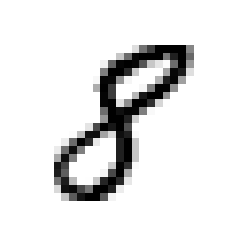

In [43]:
digit = train_data[30].reshape(28,28)
plt.imshow(digit, cmap = plt.cm.binary)
plt.axis('off')
plt.show()

In the above two cells, we predicted that at train_data[30] is an 8, and printed the actual digit to see that it was an 8 and our model was correct for this particular index.

In [46]:
print(sgd_clf.score(train_data, train_labels))

0.9083571428571429


The base accuracy above of 90.8%, is good, but we will see how much this can be improved in the next section.

<h2>Tuning the Model</h2>
The first step we will take is to scale the data and put it in a pipeline with the SGDClassifier:

In [47]:
steps = [('scaler', StandardScaler()), ('sgd', SGDClassifier())]
pipeline = Pipeline(steps)
pipeline.fit(train_data, train_labels)

Pipeline(steps=[('scaler', StandardScaler()), ('sgd', SGDClassifier())])

In [51]:
pipeline.score(train_data, train_labels)

0.9186904761904762

Above, we find an almost 2% accuracy improvement by scaling the features. Next, we will tune the hyperparameters of the model:

In [102]:
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data.astype(np.float64))
scaled_test_data = scaler.fit_transform(test_data.astype(np.float64))

In [89]:
loss = ['hinge', 'log']
penalty = ['l1', 'l2', 'elasticnet']
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100]

param_distributions = dict(loss=loss,
                           penalty=penalty,
                           alpha=alpha,
                           learning_rate=learning_rate,
                           class_weight=class_weight,
                           eta0=eta0)

sgd1 = SGDClassifier()
random = RandomizedSearchCV(estimator=sgd1, param_distributions=param_distributions, 
                            scoring='accuracy', verbose=1, n_jobs=-1, n_iter=10)

random_result = random.fit(scaled_train_data, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [79]:
print(grid_result.best_params_)

{'penalty': 'l2', 'loss': 'hinge', 'learning_rate': 'adaptive', 'eta0': 10, 'class_weight': {1: 0.5, 0: 0.5}, 'alpha': 0.001}


In [90]:
steps = [('scaler', StandardScaler()), ('sgd', SGDClassifier(loss='hinge', penalty='l2', eta0=10, alpha=.001, class_weight= {1: 0.5, 0: 0.5}, learning_rate = 'adaptive'))]
pipeline = Pipeline(steps)
pipeline.fit(train_data, train_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.001, class_weight={0: 0.5, 1: 0.5},
                               eta0=10, learning_rate='adaptive'))])

In [91]:
print(pipeline.score(train_data, train_labels))

0.9358809523809524


Above, we have improved training accuracy by an additional 1.8% by doing a random search for hyperparameter tuning. Next, we will try more tuning and new models. 

<h2>Support Vector Machine</h2>

In [101]:
from sklearn.svm import SVC

svc_classifier = SVC()
svc_classifier.fit(scaled_train_data, train_labels)

SVC()

In [108]:
svc_classifier.score(scaled_train_data, train_labels)

0.9860714285714286

In [121]:
svc_classifier.score(scaled_test_data, test_labels)

0.9576190476190476

Above are the accuracy scores of the SVM for training and testing data. On the training set, an excellent 98.6% was achieved, while a score of 95.8% was achieved on the testing set.

<AxesSubplot:>

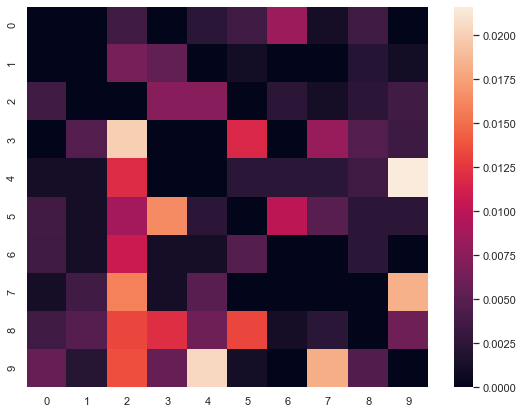

In [125]:
pred_labels = svc_classifier.predict(scaled_test_data)
matrix = confusion_matrix(test_labels, pred_labels)
row_sum = matrix.sum(axis=1, keepdims=True)
norm_matrix = matrix/row_sum
np.fill_diagonal(norm_matrix, 0)
sns.set(rc={'figure.figsize':(9,7)})
sns.heatmap(data=norm_matrix)

Above is a normalized confusion matrix for the testing data, with the diagonal set to zero. A few takeaways from this are:<ul>
    <li>True 2's are the most misclassified number.</li>
    <li>The highest misclassifcations in the test set are:</li>
        <ul>
            <li>2's being classified as 3's</li>
            <li>4's being classified as 9's</li>
            <li>9's being classified as 4's</li>
        </ul>
</ul>

<AxesSubplot:>

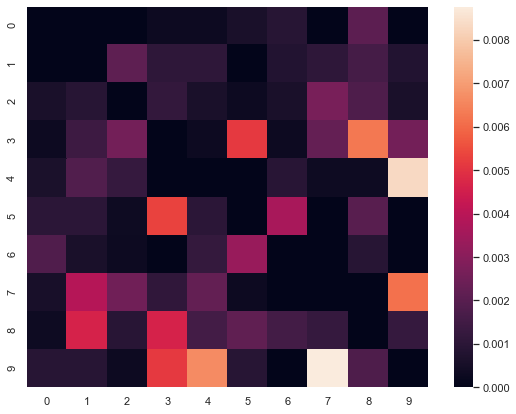

In [127]:
pred_labels = svc_classifier.predict(scaled_train_data)
matrix = confusion_matrix(train_labels, pred_labels)
row_sum = matrix.sum(axis=1, keepdims=True)
norm_matrix = matrix/row_sum
np.fill_diagonal(norm_matrix, 0)
sns.set(rc={'figure.figsize':(9,7)})
sns.heatmap(data=norm_matrix)

Above is a normalized confusion matrix for the training data, with the diagonal set to zero. A few takeaways from this are:<ul>
    <li>The highest misclassifcations in the test set are:</li>
        <ul>
            <li>7's being classified as 9's</li>
            <li>9's being classified as 4's</li>
        </ul>
</ul>

<h3>Improvements to the Model:</h3>
&emsp; &emsp;   There are several ways this model could be improved. First, feature engineering could be performed. For instance, closed loops could be traced to eliminate false positives. Example: in the training data confusion matrix, we see that 8's were confused with 3's at a significant rate. With feature engineering and tracing closed loops, the posibility of a 3 in the case of an 8 could have perhaps been eliminated by counting the two closed loops of the 8. This is beyond the scope of this project. <br>
&emsp; &emsp;   Secondly, more hyperparameter tuning on the SVC model could be performed. Initially, my goal was to perform a GridSearchCV over C, gamma, and kernel, as these are hyperparameters that contribute strongly to the accuracy of the model. However, even trying to tune 3 values for each proved to be too computationally intensive for my local machine, due to the high dimensionality of the data (785 columns). This was also a problem for running RandomSearchCV on the SGDClassifier because trying many combinations of hyperparameters was too computationally intensive as well.